In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import random

import synchrony.PlottingTools as plottingTools
from synchrony.ParameterSet import ParameterSet
import synchrony.DataStorage as dataStorage
import synchrony.DataAnalysis as dataAnalysis
import synchrony.MakeDataframe as makeDataframe
from synchrony import mainClass

In [2]:
file_path_input_params_json = '../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'Paper/Fig_A06' #'Paper/X_Appendix/A4_higher_firing_rate/A4c' or 'Paper/Fig_4/Fig_4bc'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/Synchrony/Paper/Fig_A06
parameter_path /home/berger/Data/Synchrony/Paper/Fig_A06/parameter_set.csv


In [3]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

In [4]:
def calculate_av_V_b_th(v_init, growth_rate, T_CC):
    return v_init/2 * np.exp(growth_rate* T_CC)

def calculate_av_number_origins_at_birth(doubling_time, T_CC):
    # this function determines the average number of origins present at birth (depends on relative length of TCC and the doubling time)
    ratio = T_CC / doubling_time
    conditions = [(ratio<1), (ratio>=1)&(ratio<2), (ratio>=2)&(ratio<3), (ratio>=3)&(ratio<4)]
    choiceX = [1, 2, 4, 8]
    n_ori_b = np.select(conditions, choiceX)
    return n_ori_b

def calcuate_max_rate_given_n_eff(n, growth_rate, v_init, v_b):
        return n*growth_rate * np.log(2)/np.log((2 * v_init**n)/(v_b**n+v_init**n))

In [5]:
doubling_rate = 1.5
growth_rate = np.log(2) * doubling_rate
v_init = 1
n_eff = np.arange(10, 50, 2)
k_max =  np.arange(10, 50, 2)
t_cc = 1
delay_max = 0.16
v_b = calculate_av_V_b_th(v_init, growth_rate, t_cc)
n_ori_birth = calculate_av_number_origins_at_birth(1/doubling_rate, t_cc)
v_b_per_ori = 0.4 #v_b/n_ori_birth
t_max = 15

In [6]:
print(n_eff, k_max, v_b_per_ori)

[10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48] [10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48] 0.4


# Make data frame

In [7]:
def make_two_parameter_arrays_given_two_arrays(np_array1, np_array2):
    new_np_array1 = np.array([])
    new_np_array2 = np.array([])
    for idx, value in enumerate(np_array1):
        new_np_array1 = np.append(new_np_array1, np.ones(np_array2.size)* value)
        new_np_array2 = np.append(new_np_array2, np_array2)
    return new_np_array1, new_np_array2

In [8]:
n_eff_long, k_max_long = make_two_parameter_arrays_given_two_arrays(n_eff, k_max)
data_frame = pd.DataFrame.from_dict({'n_eff': n_eff_long, 'k_max': k_max_long})

# Functions

In [9]:
def integrand_prob_two_events_new(t1, growth_rate_, v_init_, V_b_, n_, firing_rate_0_, delta_t):
    vol_t1 = V_b_ * np.exp(growth_rate_ * t1)
    vol_t1_delay = V_b_ * np.exp(growth_rate_ * (t1+ delta_t))
    prefactor = 2 * firing_rate_0_ * vol_t1**n_/(vol_t1**n_ + v_init_**n_)
    exponential = ((vol_t1_delay**n_ + v_init_**n_) * (vol_t1**n_ + v_init_**n_)/(V_b_**n_ + v_init_**n_)**2)**(-firing_rate_0_/(growth_rate_ * n_))
    return prefactor * exponential

def waiting_time_dist_indef(time_, growth_rate_, effective_hill_coeff_, v_init_, V_b_, firing_rate_0_):
    vol = V_b_ * np.exp(growth_rate_* time_)
    prefactor = firing_rate_0_ * vol**effective_hill_coeff_ / (vol**effective_hill_coeff_ + v_init_**effective_hill_coeff_ )
    return prefactor * calculate_survival_probability_indefinite(time_, 
                                                                 growth_rate_, 
                                                                 effective_hill_coeff_, 
                                                                 v_init_, 
                                                                 V_b_,
                                                                 firing_rate_0_)

def calculate_survival_probability_indefinite(time_, growth_rate_, effective_hill_coeff_, v_init_, V_b_, firing_rate_0_):
    return np.exp(- firing_rate_0_ / (growth_rate_ * effective_hill_coeff_) 
                  * np.log(v_init_**effective_hill_coeff_ + (V_b_ * np.exp(growth_rate_ * time_))**effective_hill_coeff_))

def integrand_mean(time, growth_rate_, v_init_, V_b_, n_, rate):
    return waiting_time_dist_indef(time, growth_rate_, n_, v_init_, V_b_, rate) * (V_b_ * np.exp(growth_rate_ * time))

def calculate_mean_theoretical(growth_rate_, v_init_, V_b_, n_, rate, t_d_):
    result = integrate.quad(lambda x: integrand_mean(x, growth_rate_, v_init_, V_b_, n_, rate), 0, t_d_)
    return result

def calculate_fraction_from_prob(prob):
    return prob + (1-prob)* 0.5

In [10]:
data_frame.loc[:, 'theoretical_prediction'] = data_frame.apply(lambda row: 1-integrate.quad(lambda x: integrand_prob_two_events_new(x,
                                                                                               growth_rate,
                                                                                               v_init,
                                                                                               v_b_per_ori,
                                                                                               row.n_eff, 
                                                                                               row.k_max,
                                                                                               delay_max) , 0,  13)[0], axis = 1)

data_frame.loc[:, 'th_deg_synch'] = data_frame.apply(lambda row: calculate_fraction_from_prob(row.theoretical_prediction), axis = 1)

# data_frame.loc[:, 'theoretical_mean'] = data_frame.apply(lambda row: calculate_mean_theoretical(growth_rate,
#                                   v_init,
#                                   v_b_per_ori,
#                                   row.n_eff,
#                                   row.k_max,
#                                   t_max
#                                  )[0], axis = 1)

/home/berger/.virtualenvs/synchrony_project/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """


In [11]:
data_frame

,n_eff,k_max,theoretical_prediction,th_deg_synch
0,10.0,10.0,0.502442,0.751221
1,10.0,12.0,0.527916,0.763958
2,10.0,14.0,0.547405,0.773702
3,10.0,16.0,0.562738,0.781369
4,10.0,18.0,0.575082,0.787541
...,...,...,...,...
395,48.0,40.0,0.990921,0.995461
396,48.0,42.0,0.992163,0.996081
397,48.0,44.0,0.993176,0.996588
398,48.0,46.0,0.994007,0.997004


# Plot

## Heatmap of degree of synchrony at different (k_max, n_eff)

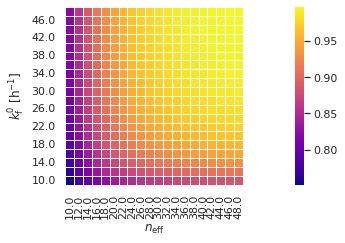

In [12]:
import matplotlib.colors as colors
import matplotlib as mpl

data_frame_ordered = data_frame.sort_values(by=["k_max"])
heatmap_df = data_frame_ordered.pivot("k_max", "n_eff", "th_deg_synch")

cmap = mpl.cm.get_cmap("plasma").copy()
# cmap.set_over('darkred')
sns.set(rc={'figure.figsize': (18.7, 3.27)})
ax = sns.heatmap(heatmap_df, 
            square=True, 
            linewidths=.5,
            cmap=cmap)
ax.invert_yaxis()

# ax.set_title(r'$s= \frac{n_{\rm ori}(t_{\rm i})}{n_{\rm ori}(t_{\rm f})- n_{\rm ori}(t_{\rm i})}$')
ax.set_facecolor('grey')
ax.set(ylabel=r'$k_{\rm f}^0}$ [h$^{-1}$]', xlabel=r'$n_{\rm eff}$')
plt.savefig(file_path + '/degree_synch_not_covaried.png', format='png', bbox_inches='tight', dpi=400)

## Contour plot

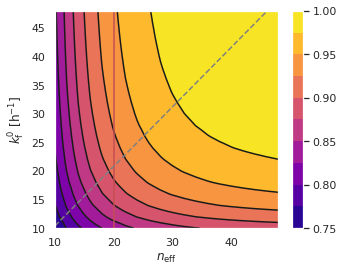

In [13]:
import matplotlib.colors as colors
import matplotlib as mpl

data_frame_ordered = data_frame.sort_values(by=["k_max"])
cmap = mpl.cm.get_cmap("seismic").copy()
cmap.set_over('darkred')
fig, ax = plt.subplots(1, figsize=(5,4))
tcf= plt.tricontourf(data_frame_ordered.n_eff,
               data_frame_ordered.k_max,
               data_frame_ordered.th_deg_synch,
               cmap='plasma',
                    levels=10)
plt.tricontour(data_frame_ordered.n_eff,
               data_frame_ordered.k_max,
               data_frame_ordered.th_deg_synch, colors='k',
                    levels=10)
ax.set(ylabel=r'$k_{\rm f}^0}$ [h$^{-1}$]', xlabel=r'$n_{\rm eff}$')
fig.colorbar(tcf)
plt.axvline(20, color='r')
# plt.xticks(np.arange(10, 30, 5)) 
plt.plot(n_eff[:-1], calcuate_max_rate_given_n_eff(n_eff[:-1], growth_rate, v_init, v_b_per_ori), color='grey', linestyle='--')
plt.savefig(file_path + '/fig_A11a_isolines.png', format='png', bbox_inches='tight', dpi=400)